In [ ]:
!pip install gdown


!gdown 16EuPTzv2sGWlKdoPhqHm3pNN3A5iNiwv
!unzip  -q coco_traffic_images.zip
!rm -r coco_traffic_images.zip

!gdown 16zhU7CvGkXadhxT-Un7jr2xTTLgNNhAh
!unzip -q val_coco_traffic.zip
!rm -r val_coco_traffic.zip

!gdown 1R42e1MTYb3koKVPl6UyulXr9mjtP8h4S
!unzip -q train_coco_traffic.zip
!rm -r train_coco_traffic.zip

!gdown  1xVaQuv9j5YxyuiuXuzCPGSZIndEhhYdn




Downloading...
From (original): https://drive.google.com/uc?id=16EuPTzv2sGWlKdoPhqHm3pNN3A5iNiwv
From (redirected): https://drive.google.com/uc?id=16EuPTzv2sGWlKdoPhqHm3pNN3A5iNiwv&confirm=t&uuid=d354b90f-ecfe-4839-84ce-68f1022add8f
To: /kaggle/working/coco_traffic_images.zip
100%|███████████████████████████████████████| 3.30G/3.30G [00:20<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=16zhU7CvGkXadhxT-Un7jr2xTTLgNNhAh
To: /kaggle/working/val_coco_traffic.zip
100%|██████████████████████████████████████| 6.49M/6.49M [00:00<00:00, 74.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1R42e1MTYb3koKVPl6UyulXr9mjtP8h4S
From (redirected): https://drive.google.com/uc?id=1R42e1MTYb3koKVPl6UyulXr9mjtP8h4S&confirm=t&uuid=e4605b84-b139-4ce2-abb7-2b5aa590a0e2
To: /kaggle/working/train_coco_traffic.zip
100%|█████████████████████████████████████████| 146M/146M [00:01<00:00, 110MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1xVaQuv9j5Yxyu

In [ ]:
import cv2
import json
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os
import albumentations as A


COLORMAP = [(0,   0,   0),
            (0,   128, 0),
            (0,   0,   255),
            (255, 255, 0),
            (255, 0,   0),
            (160, 32,  240)]


transforms = A.Compose([
    A.Normalize(
        mean=[0., 0., 0.],
        std=[1, 1, 1],
    ),
], bbox_params=A.BboxParams(format='coco',label_fields=['class_labels']))


train_transforms = A.Compose([
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Normalize(
        mean=[0., 0., 0.],
        std=[1, 1, 1],
    ),
], bbox_params=A.BboxParams(format='coco',label_fields=['class_labels']))





CLASSES = ['background','bicycle', 'bus', 'car', 'motorcycle', "person"]

class ODCOCOTrafficDataset(Dataset):

    def __init__(self, anno_path, img_dir, transforms):
      self.img_root = img_dir + '/%s.jpg'
      ids, annos = self._load_annos(anno_path)
      self.ids = list(ids)
      self.annos = list(annos)
      self.transforms = transforms

      self.class_to_ind = dict(
            zip(CLASSES, range(len(CLASSES))))

    def _load_annos(self, anno_path):
        with open(anno_path, 'r') as file:
          data = json.load(file)
          return data.keys(), data.values()

    def __len__(self):
        return len(self.ids)


    def __getitem__(self, idx):
        img_path = self.img_root % self.ids[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        anno = self.annos[idx]
        boxes = []
        labels = []

        for i in range(len(anno[0])):
          boxes.append(anno[0][i])
          labels.append(self.class_to_ind[anno[1][i]])

        if self.transforms is not None:
          transformed = self.transforms(image=img, bboxes=boxes, class_labels=labels)
          img = transformed['image']
          boxes = transformed['bboxes']
          boxes = self._bboxes_coco2yolo(boxes)
          labels = transformed['class_labels']

        return torch.tensor(img).permute(2, 0, 1), boxes, labels

    def _bboxes_coco2yolo(self, bboxes):
        bboxes = torch.tensor(bboxes)
        bboxes[:, 2] += bboxes[:, 0]
        bboxes[:, 3] += bboxes[:, 1]
        return bboxes



def detection_collate(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0].float())
        target = {'boxes':[], 'labels':[]}
        for i in range(len(sample[1])):
          target['boxes'].append(sample[1][i])
          target['labels'].append(sample[2][i])
        target['boxes'] = torch.FloatTensor(np.array(target['boxes']))
        target['labels'] = torch.tensor(target['labels'],  dtype=torch.int64)
        targets.append(target)
    return imgs,  targets


In [ ]:
import time
import matplotlib.pyplot as plt

from torch.cuda.amp import GradScaler

def load_checkpoint(ckpt_path):
    print(f"Load checkpoint from: {ckpt_path}")
    checkpoint = torch.load(ckpt_path)
    model_state_dict = checkpoint['model_state_dict']
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    loss_dict = checkpoint['loss_dict']
    current_epoch = checkpoint['current_epoch']

    return model_state_dict, optimizer_state_dict, loss_dict, current_epoch


def save_checkpoint(model, optimizer, loss_dict, epoch, num_epochs, out_dir='./', model_name=''):
  save_path_format = f'%s/%s_epoch_%s_ckpt.pt'
  save_path = save_path_format % (out_dir, model_name, epoch)

  print(f'=> save_checkpoint: {save_path}')
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss_dict':loss_dict,
      'current_epoch': epoch,
      'num_epochs':num_epochs

  }, save_path)



def prepare_map_input(model, data_loader, device,  epoch, out_dir='./', model_name=''):
    print('prepare_map_input'.center(50, '='))
    model.eval()
    model = model.to(device)
    map_input = []
    total_time = 0
    total_steps = len(data_loader)
    with torch.no_grad():
        data_iter = iter(data_loader)
        for step in range(total_steps):
            st = time.time()
            images, targets = next(data_iter)
            images = [image.to(device) for image in images]
            preds = model(images)
            for i in range(len(preds)):
                preds[i]['boxes'] = preds[i]['boxes'].cpu()
                preds[i]['labels'] = preds[i]['labels'].cpu()
                preds[i]['scores'] = preds[i]['scores'].cpu()

            map_input.append([preds, targets])
            torch.cuda.empty_cache()
            time_step = time.time() - st
            total_time += time_step
            avg_time_step = total_time/(step+1)
            remaining_time = avg_time_step * (total_steps-step-1)

            if (step + 1)%10 == 0:
                print(f"Step: [{step+1}/{total_steps}], time_step: {time_step:.2f}s, avg_time_step: {avg_time_step:.2f}s | [{total_time:.2f}s / {remaining_time:.2f}s]")
    save_path_format = f'%s/map_input_%s_epoch_%s.pt'
    save_path = save_path_format % (out_dir, model_name, epoch)

    torch.save(map_input, save_path)



def smooth_line(data, alpha=0.1):
    smoothed_data = []
    ema = data[0]
    for value in data:
        ema = alpha * ema + (1 - alpha) * value
        smoothed_data.append(ema)
    return smoothed_data

def plot_loss(losses, loc_loss, conf_loss, title='Train loss', st=0):
    # Plot the 3 lists
    end_index = len(losses)
    st_index  = end_index - st

    x = list(range(st_index, end_index))
    losses = smooth_line(losses[st_index:end_index])
    loc_loss = smooth_line(loc_loss[st_index:end_index])
    conf_loss = smooth_line(conf_loss[st_index:end_index])

    alpha = 0.9
    smoothed_losses = []
    ema = losses[0]
    for loss in losses:
        ema = alpha * ema + (1 - alpha) * loss
        smoothed_losses.append(ema)

    plt.figure(figsize=(8, 6))
    plt.plot(x, losses, label='losses')
    plt.plot(x, loc_loss, label='loc_loss')
    plt.plot(x, conf_loss, label='conf_loss')

    # Add labels and title
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()

    plt.show()

scaler = GradScaler()

def train(model, optimizer, loss_dict, current_epoch, train_loader, test_loader, num_epochs, device, out_dir, model_name):
    model.to(device)

    total_steps = len(train_loader)
    print_step = total_steps//100
    global_total_time = time.time()
    for epoch in range(current_epoch, num_epochs):
        model.train()
        total_time = 0
        train_iter = iter(train_loader)
        for step in range(total_steps):
            try:
                st = time.time()
                imgs, targets = next(train_iter)
                imgs = [img.to(device) for img in imgs]
                for idx in range(len(targets)):
                    targets[idx]['boxes'] =  targets[idx]['boxes'].to(device)
                    targets[idx]['labels'] = targets[idx]['labels'].to(device)

                with torch.autocast(device_type="cuda"):
                    losses = model(imgs, targets)
                    loss_loc = losses['bbox_regression']
                    loss_conf = losses['classification']
                    loss = loss_loc + loss_conf



                scaler.scale(loss).backward()
                loss = loss.cpu().detach()
                loss_loc = loss_loc.cpu().detach()
                loss_conf = loss_conf.cpu().detach()
                torch.cuda.empty_cache()

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

                time_step = time.time() - st
                total_time += time_step
                avg_time_step = total_time/(step+1)

                remaining_time = avg_time_step * (total_steps-step-1)

                if (step + 1) % print_step == 0:
                    loss_dict['losses'].append(loss)
                    loss_dict['loc_loss'].append(loss_loc)
                    loss_dict['conf_loss'].append(loss_conf)

                    print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{step+1}/{total_steps}], losses: {loss:.4f}, conf_loss: {loss_conf:.4f}, loc_loss: {loss_loc:.4f}, time_step: {time_step:.2f}s, avg_time_step: {avg_time_step:.2f}s | [{total_time:.2f}s / {remaining_time:.2f}s]')
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

        save_checkpoint(model, optimizer, loss_dict,  epoch+1, num_epochs, out_dir, model_name)
        prepare_map_input(model, test_loader, device,  epoch+1, out_dir, model_name)

        plot_loss(st=len(loss_dict['losses']), **loss_dict)
        plot_loss(st=100, title=f'Train loss (epoch: {epoch+1})', **loss_dict)


    global_total_time -= time.time()
    global_total_time /= 60
    print(f'global_total_time: {-global_total_time:.2f} minutes')

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import math

from torchvision.models.detection import retinanet_resnet50_fpn_v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model = retinanet_resnet50_fpn_v2(weights='DEFAULT')

cls_logits = nn.Conv2d(256, 6*9, kernel_size=3, stride=1, padding=1)
nn.init.normal_(cls_logits.weight, std=0.01)
nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))


model.num_classes = 6
model.head.classification_head.num_classes = 6
model.head.classification_head.cls_logits = cls_logits




Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:00<00:00, 157MB/s]  


Load checkpoint from: /kaggle/working/retinanet_epoch_4_ckpt.pt
Epoch: [5/6], Step: [11/1107], losses: 0.3855, conf_loss: 0.1942, loc_loss: 0.1913, time_step: 2.04s, avg_time_step: 2.09s | [22.99s / 2290.25s]
Epoch: [5/6], Step: [22/1107], losses: 0.3689, conf_loss: 0.1951, loc_loss: 0.1738, time_step: 1.99s, avg_time_step: 2.05s | [45.18s / 2228.32s]
Epoch: [5/6], Step: [33/1107], losses: 0.3969, conf_loss: 0.1783, loc_loss: 0.2186, time_step: 1.95s, avg_time_step: 2.05s | [67.67s / 2202.21s]
Epoch: [5/6], Step: [44/1107], losses: 0.3419, conf_loss: 0.1695, loc_loss: 0.1725, time_step: 2.14s, avg_time_step: 2.06s | [90.50s / 2186.44s]
Epoch: [5/6], Step: [55/1107], losses: 0.4456, conf_loss: 0.2300, loc_loss: 0.2156, time_step: 2.03s, avg_time_step: 2.06s | [113.39s / 2168.88s]
Epoch: [5/6], Step: [66/1107], losses: 0.3972, conf_loss: 0.2002, loc_loss: 0.1970, time_step: 2.14s, avg_time_step: 2.07s | [136.40s / 2151.41s]
Epoch: [5/6], Step: [77/1107], losses: 0.3035, conf_loss: 0.1573

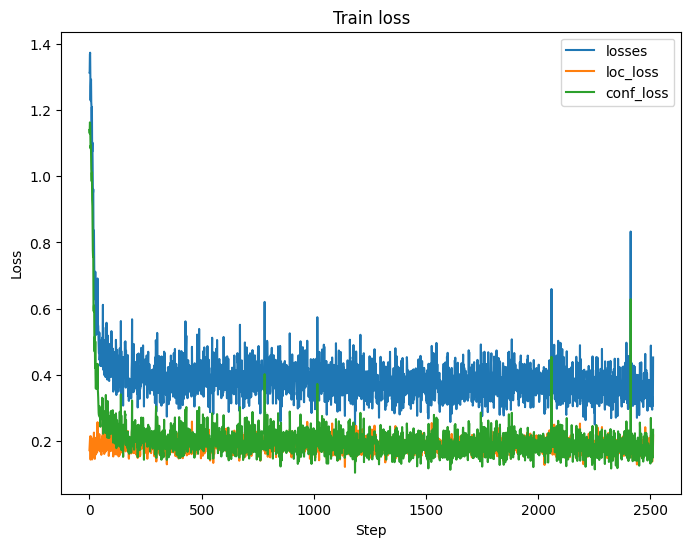

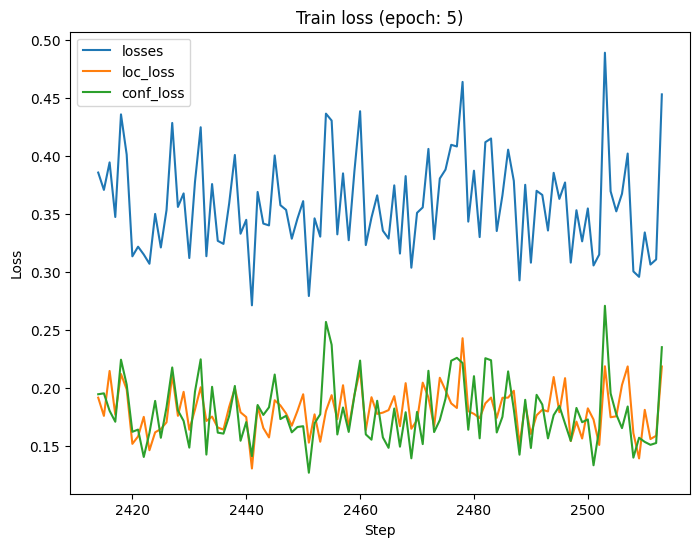

Epoch: [6/6], Step: [11/1107], losses: 0.3358, conf_loss: 0.1681, loc_loss: 0.1677, time_step: 2.12s, avg_time_step: 2.15s | [23.61s / 2352.50s]
Epoch: [6/6], Step: [22/1107], losses: 0.3457, conf_loss: 0.1698, loc_loss: 0.1759, time_step: 1.98s, avg_time_step: 2.07s | [45.58s / 2247.85s]
Epoch: [6/6], Step: [33/1107], losses: 0.3283, conf_loss: 0.1579, loc_loss: 0.1704, time_step: 2.01s, avg_time_step: 2.06s | [68.10s / 2216.26s]
Epoch: [6/6], Step: [44/1107], losses: 0.3387, conf_loss: 0.1751, loc_loss: 0.1636, time_step: 1.96s, avg_time_step: 2.03s | [89.38s / 2159.46s]
Epoch: [6/6], Step: [55/1107], losses: 0.4091, conf_loss: 0.2143, loc_loss: 0.1948, time_step: 2.21s, avg_time_step: 2.02s | [111.35s / 2129.88s]
Epoch: [6/6], Step: [66/1107], losses: 0.4174, conf_loss: 0.2245, loc_loss: 0.1928, time_step: 1.94s, avg_time_step: 2.03s | [133.83s / 2110.89s]
Epoch: [6/6], Step: [77/1107], losses: 0.3744, conf_loss: 0.2035, loc_loss: 0.1710, time_step: 1.74s, avg_time_step: 2.02s | [15

In [ ]:
num_workers = os.cpu_count()

train_anno_path = '/kaggle/working/train_anno_traffic.json'
train_img_dir = '/kaggle/working/coco_traffic_images'
test_anno_path = '/kaggle/working/val_anno_traffic.json'
test_img_dir = '/kaggle/working/coco_traffic_images'
model_name = 'retinanet'
out_dir = '/kaggle/working'
ckpt_path = '/kaggle/working/retinanet_epoch_4_ckpt.pt'

num_epochs = 6
lr = 0.0001
batch_size = 16
current_epoch = 0

loss_dict = dict(
    losses=[],
    loc_loss=[],
    conf_loss=[]
)

torch.manual_seed(0)

if os.path.exists(ckpt_path):
  (model_state_dict, optimizer_state_dict,
                   loss_dict, current_epoch) = load_checkpoint(ckpt_path)
  model.load_state_dict(model_state_dict)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
  optimizer.load_state_dict(optimizer_state_dict)
  torch.manual_seed(current_epoch+1)
else:
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)


train_set = ODCOCOTrafficDataset(train_anno_path, train_img_dir,
                                  train_transforms)

test_set = ODCOCOTrafficDataset(test_anno_path, test_img_dir,
                                transforms)


train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, collate_fn=detection_collate,
                          num_workers=num_workers)

test_loader = DataLoader(test_set, batch_size=batch_size,
                          shuffle=False, collate_fn=detection_collate,
                          num_workers=num_workers)


for param in model.backbone.parameters():
    param.requires_grad = False

assert num_epochs > current_epoch, 'num_epochs must be greater than current_epoch'
train(model, optimizer, loss_dict, current_epoch, train_loader, test_loader, num_epochs, device, out_dir, model_name)





In [ ]:

!wget -O people_horse.jpg https://keyassets.timeincuk.net/inspirewp/live/wp-content/uploads/sites/14/2023/01/TA7899-2-920x518.jpg
!wget -O planes.jpg https://image.cnbcfm.com/api/v1/image/107177246-1673454132712-gettyimages-1246154739-AFP_336V8DZ.jpeg
!wget -O people.jpg  https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/2011_MuchMusic_Video_Awards_-_Foster_the_People.jpg/800px-2011_MuchMusic_Video_Awards_-_Foster_the_People.jpg
